In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import os
import glob
from PIL import Image

import shutil
import random

In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
dataset_path = r"D:\Monte Carlo Digital\Projeto Flores e Vegetais\archive\flowers"

total_images = 0
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images =    len(glob.glob(os.path.join(class_path, "*.jpg"))) + \
                        len(glob.glob(os.path.join(class_path, "*.jpeg"))) + \
                        len(glob.glob(os.path.join(class_path, "*.png")))
        class_counts[class_name] = num_images
        total_images += num_images

print("Total de Imagens Encontradas:", total_images)
print("\nImagens por classe:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} imagens")      

Total de Imagens Encontradas: 4317

Imagens por classe:
daisy: 764 imagens
dandelion: 1052 imagens
rose: 784 imagens
sunflower: 733 imagens
tulip: 984 imagens


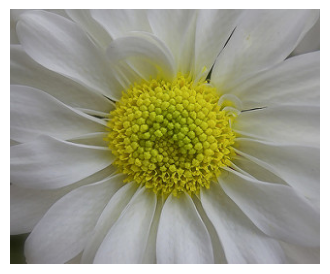

In [4]:
folder_name = os.path.join(dataset_path, "daisy")

folder_images = glob.glob(os.path.join(folder_name, "*.jpg")) + \
                glob.glob(os.path.join(folder_name, "*.jpeg")) + \
                glob.glob(os.path.join(folder_name, "*.png"))

if folder_images:
    img = Image.open(folder_images[0])

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
else:
    print("Nenhuma imagem encontrada na pasta ", folder_name)

In [5]:
original_dataset_path = r"D:\Monte Carlo Digital\Projeto Flores e Vegetais\archive\flowers"
output_path = r"D:\Monte Carlo Digital\Projeto Flores e Vegetais\archive\flowers_split"

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

if os.path.exists(output_path) and all(os.path.exists(os.path.join(output_path, split)) for split in ["train", "validation", "test"]):
    print("Divisão de dados já realizada.\n")

    dataset_summary = {"train": {}, "validation": {}, "test": {}}

    for split in ["train", "validation", "test"]:
        print(f"Pasta {split.upper()} Conjunto:")
        for class_name in os.listdir(os.path.join(output_path, split)):
            class_path = os.path.join(output_path, split, class_name)
            if os.path.isdir(class_path):
                num_images = len(os.listdir(class_path))
                dataset_summary[split][class_name] = num_images
                print(f"{class_name}: {num_images} imagens")
        print()

else:   
    print("Dividir o conjunto de imagens em Train, Validation e Test.\n")

    for split in ["train", "validation", "test"]:
        for class_name in os.listdir(original_dataset_path):
            os.makedirs(os.path.join(output_path, split, class_name), exist_ok=True)

    for class_name in os.listdir(original_dataset_path):
        class_path = os.path.join(original_dataset_path, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            random.shuffle(images)

            train_split = int(train_ratio * len(images))
            val_split = int(val_ratio * len(images)) + train_split

            for i, image in enumerate(images):
                src_path = os.path.join(class_path, image)

                if i < train_split:
                    dst_path = os.path.join(output_path, "train", class_name, image)
                elif i < val_split:
                    dst_path = os.path.join(output_path, "validation", class_name, image)
                else:
                    dst_path = os.path.join(output_path, "test", class_name, image)
                
                shutil.copy(src_path, dst_path)

    print("Dados divididos com sucesso.\n")

Divisão de dados já realizada.

Pasta TRAIN Conjunto:
daisy: 611 imagens
dandelion: 841 imagens
rose: 627 imagens
sunflower: 586 imagens
tulip: 787 imagens

Pasta VALIDATION Conjunto:
daisy: 76 imagens
dandelion: 105 imagens
rose: 78 imagens
sunflower: 73 imagens
tulip: 98 imagens

Pasta TEST Conjunto:
daisy: 77 imagens
dandelion: 106 imagens
rose: 79 imagens
sunflower: 74 imagens
tulip: 99 imagens



In [6]:
dataset_path = r"D:\Monte Carlo Digital\Projeto Flores e Vegetais\archive\flowers_split"

train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False # Não embaralhe para manter a ordem na avaliação
)

class_labels = list(train_generator.class_indices.keys())
print("Classes:", class_labels)

Found 3452 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 435 images belonging to 5 classes.
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [7]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(len(class_labels), activation='softmax')  
])

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

d:\Monte Carlo Digital\Projeto Flores e Vegetais\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
EPOCHS = 10
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=EPOCHS
)

d:\Monte Carlo Digital\Projeto Flores e Vegetais\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 78s 635ms/step - accuracy: 0.4058 - loss: 1.3870 - val_accuracy: 0.5628 - val_loss: 1.0938
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 375ms/step - accuracy: 0.5858 - loss: 1.0613 - val_accuracy: 0.6442 - val_loss: 0.9590
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 357ms/step - accuracy: 0.6625 - loss: 0.8575 - val_accuracy: 0.6814 - val_loss: 0.8059
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 338ms/step - accuracy: 0.7293 - loss: 0.7149 - val_accuracy: 0.6837 - val_loss: 0.8915
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 345ms/step - accuracy: 0.7940 - loss: 0.5770 - val_accuracy: 0.6884 - val_loss: 0.8429
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 339ms/step - accuracy: 0.8504 - loss: 0.4227 - val_accuracy: 0.6953 - val_loss: 0.9198
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 341ms/step - accuracy: 0.9068 - loss: 0.2706 - val_accuracy: 0.7186 - val_loss: 0.9698
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 43s 394ms/step - accuracy: 0.9499 - loss: 0

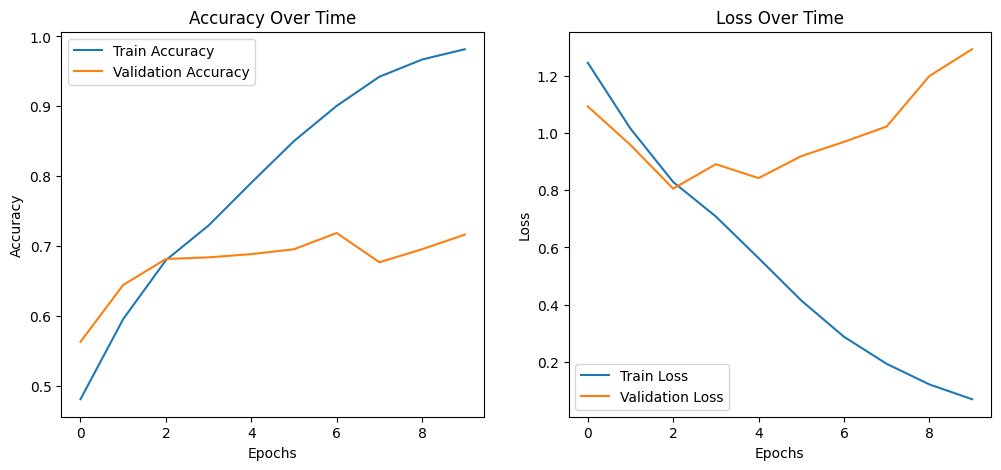

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Time')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.6695 - loss: 1.4637

 Test Accuracy: 65.29%
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step


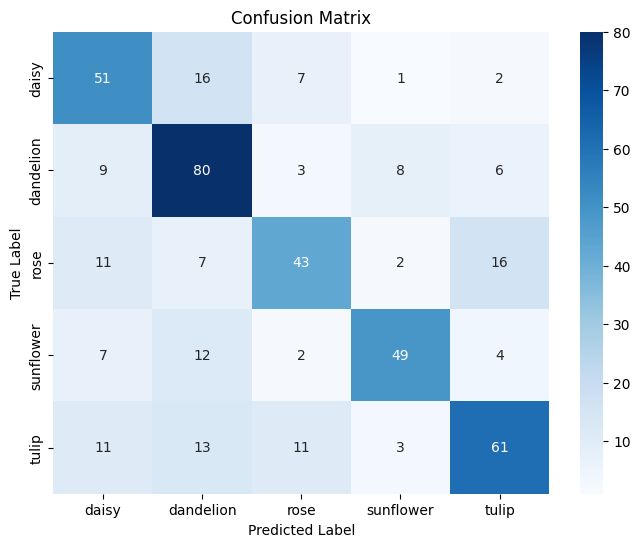


 Classification Report:
               precision    recall  f1-score   support

       daisy       0.57      0.66      0.61        77
   dandelion       0.62      0.75      0.68       106
        rose       0.65      0.54      0.59        79
   sunflower       0.78      0.66      0.72        74
       tulip       0.69      0.62      0.65        99

    accuracy                           0.65       435
   macro avg       0.66      0.65      0.65       435
weighted avg       0.66      0.65      0.65       435



In [10]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\n Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\n Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

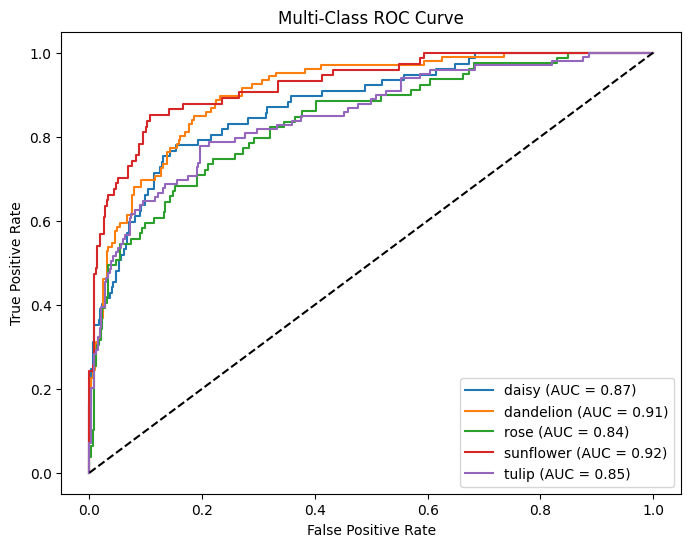

In [11]:
# Análise ROC e AUC
# Converter classes true label para one-hot encoding para permitir uma multi-class ROC-AUC
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))

# Plotar Curva ROC para cada classe
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.show()